# MACHINE LEARNING MODELS - SEPARATE LAYERS

In this notebook, we deploy machine learning models to the data obtained from applying graph measures to each layer individually.


In [3]:
# Import libraries and functions

#Data Science usual libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score


#OverSampling and UnderSampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

### Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# define random_state
RANDOM_STATE = 3

%matplotlib inline

### 1. Load data

We load our csv into a dataframe using pandas.

In [4]:
## Define paths

dataDir = "/data/"
separate_layers = "separate_layers.csv"

separate_layers = pd.read_csv(dataDir + separate_layers)

In [5]:
separate_layers.shape

(165, 104)

In [6]:
separate_layers.head()

,id,controls_ms,mstype,age,sex,dd,edss,FA_diameter,FA_gl-efficiency,FA_mean_path-length,...,FA_loc-clos-cent_ctx-rh-precentral,FA_loc-clos-cent_ctx-rh-rostralanteriorcingulate,FA_loc-clos-cent_ctx-rh-superiorfrontal,FA_loc-clos-cent_ctx-rh-supramarginal,FA_loc-clos-cent_ctx-rh-transversetemporal,GM_loc-strength_ctx-lh-rostralmiddlefrontal,fMRI_loc-clos-cent_ctx-lh-entorhinal,fMRI_loc-clos-cent_Right-Amygdala,fMRI_loc-clos-cent_ctx-rh-entorhinal,fMRI_loc-clos-cent_ctx-rh-paracentral
0,002MSVIS,PwMS,SPMS,51.53,Male,22.18,7.5,0.749329,2.723527,0.404413,...,0.032926,0.035895,0.034425,0.035408,0.034443,6.890250,0.262300,0.188231,0.224069,0.207830
1,003MSVIS,PwMS,PPMS,58.06,Female,9.57,6.0,0.685088,2.643900,0.405654,...,0.035146,0.034714,0.032668,0.033092,0.030905,8.385633,0.191097,0.164313,0.176306,0.269140
2,004MSVIS,PwMS,RRMS,60.78,Male,6.79,3.0,0.739964,2.652358,0.413579,...,0.033177,0.035793,0.033172,0.032197,0.033935,9.998207,0.228344,0.316949,0.198180,0.316036
3,005MSVIS,PwMS,RRMS,37.95,Female,8.45,1.5,0.857654,2.309886,0.464976,...,0.027081,0.028645,0.029161,0.028574,0.025907,9.298109,0.341972,0.307553,0.175626,0.183286
4,010MSVIS,PwMS,RRMS,52.64,Female,9.05,2.0,0.757653,2.576118,0.419794,...,0.032857,0.034034,0.034274,0.031715,0.030174,7.706899,0.239808,0.406199,0.337893,0.424529


In [7]:
all_data = separate_layers.copy()

## 2. Remove highly correlated data

Graph measures could exhibit high correlation (for example, diameter measures and mean path length, different centrality measures, and so on). Most machine learning algorithms perform better without highly correlated features. Therefore, we will remove any columns that are significantly correlated with others, retaining only one representative measure from each set of correlated measures.

We set our threshold at 0.8, accounting for both positive and negative correlations, and remove all correlated columns over (or below) threshold.

In [8]:
selected_columns = all_data.iloc[:, 7:] 
colnames = list(selected_columns)

pos_threshold = 0.8
neg_threshold = -0.8

highly_correlated_columns = {} #Dictionary to store correlations
columns_to_remove = []
for i,colname in enumerate(colnames):
    columns_to_dict = [] # Dictionary values
    if selected_columns.columns[i] not in columns_to_remove: #Column not in the list to remove
        for j in range(i+1, len(colnames)):
            if selected_columns.columns[j] not in columns_to_remove: #Column not in the list to remove
                matrix_coef = np.corrcoef(selected_columns.iloc[:, i], selected_columns.iloc[:, j]) 
                if matrix_coef[0,1] > pos_threshold or matrix_coef[0,1] < neg_threshold:
                    columns_to_remove.append(selected_columns.columns[j])
                    columns_to_dict.append(selected_columns.columns[j])
        highly_correlated_columns[colname] = columns_to_dict

columns_to_remove = set(columns_to_remove) #just in case we have some repeated columns
print("Can remove " +str(len(columns_to_remove)) + " features")

# Select column that are not in the list
filtered_columns = [col for col in selected_columns.columns if col not in columns_to_remove] 
filtered_df = selected_columns[filtered_columns]

# Final dataframe
final_data = pd.concat([all_data.iloc[:, :7], filtered_df], join = "inner", axis = 1)
final_data.head()


Can remove 86 features


,id,controls_ms,mstype,age,sex,dd,edss,FA_diameter,FA_gl-strength,fMRI_gl-efficiency,fMRI_mean_path-length,fMRI_gl-transitivity,FA_loc-clos-cent_ctx-rh-caudalanteriorcingulate,GM_loc-strength_ctx-lh-rostralmiddlefrontal,fMRI_loc-clos-cent_ctx-lh-entorhinal,fMRI_loc-clos-cent_Right-Amygdala,fMRI_loc-clos-cent_ctx-rh-entorhinal,fMRI_loc-clos-cent_ctx-rh-paracentral
0,002MSVIS,PwMS,SPMS,51.53,Male,22.18,7.5,0.749329,20.683822,34.887033,0.059262,0.975455,0.034447,6.890250,0.262300,0.188231,0.224069,0.207830
1,003MSVIS,PwMS,PPMS,58.06,Female,9.57,6.0,0.685088,21.561644,26.403461,0.061415,0.966835,0.036082,8.385633,0.191097,0.164313,0.176306,0.269140
2,004MSVIS,PwMS,RRMS,60.78,Male,6.79,3.0,0.739964,22.625097,29.982327,0.053033,0.960516,0.029814,9.998207,0.228344,0.316949,0.198180,0.316036
3,005MSVIS,PwMS,RRMS,37.95,Female,8.45,1.5,0.857654,22.236905,31.152743,0.055629,0.977091,0.029511,9.298109,0.341972,0.307553,0.175626,0.183286
4,010MSVIS,PwMS,RRMS,52.64,Female,9.05,2.0,0.757653,20.812184,31.347753,0.047155,0.964302,0.031297,7.706899,0.239808,0.406199,0.337893,0.424529


In [9]:
final_data.shape

(165, 18)

In [10]:
len_correlations ={key:len(highly_correlated_columns[key]) for key in highly_correlated_columns.keys()}
len_correlations

{'FA_diameter': 85,
 'FA_gl-strength': 0,
 'fMRI_gl-efficiency': 0,
 'fMRI_mean_path-length': 0,
 'fMRI_gl-transitivity': 1,
 'FA_loc-clos-cent_ctx-rh-caudalanteriorcingulate': 0,
 'GM_loc-strength_ctx-lh-rostralmiddlefrontal': 0,
 'fMRI_loc-clos-cent_ctx-lh-entorhinal': 0,
 'fMRI_loc-clos-cent_Right-Amygdala': 0,
 'fMRI_loc-clos-cent_ctx-rh-entorhinal': 0,
 'fMRI_loc-clos-cent_ctx-rh-paracentral': 0}

Upon examining the measures correlated with the *FA diameter*, we find that they all originate from the FA layer.

In [11]:
# Create an empty dictionary to store the counts
counts = {}

# Loop over the strings in the list
for string in highly_correlated_columns['FA_diameter']:
    # Split the string on '_' and take the first part (the type)
    type_ = string.split('_')[0]
    # If the type is already in the dictionary, increment its count
    if type_ in counts:
        counts[type_] += 1
    # If the type is not in the dictionary, add it with a count of 1
    else:
        counts[type_] = 1

print(counts)

{'FA': 85}


It appears correlated measures mainly come from 2 different measurements.

In [12]:
# The substrings we are looking for
substring1 = 'loc-eff'
substring2 = 'loc-clos-cent'
# Initialize the count to 0
count1 = 0
count2 = 0
# Loop over the strings in the list
for string in highly_correlated_columns['FA_diameter']:
    # Add the count of the substring in the current string to the total count
    count1 += string.count(substring1)
    count2 += string.count(substring2)

print(f"{substring1} count: {count1}")
print(f"{substring2} count: {count2}")

loc-eff count: 56
loc-clos-cent count: 27


## 3. Imbalanced data

Remember that our data is imbalanced. We have 18 HS and 147 PwMS

In [13]:
final_data['controls_ms'].value_counts()

PwMS    147
HS       18
Name: controls_ms, dtype: int64

It is also imbalanced in patients with different MS types. There are only 6 patients with type PPMS

In [14]:
final_data['mstype'].value_counts()

RRMS    125
HS       18
SPMS     16
PPMS      6
Name: mstype, dtype: int64

We need to employ a data augmentation algorithm. I will utilize SMOTE, a well-known and widely used method. SMOTE tends to perform slightly better when, in addition to oversampling the minority class, the majority class is also undersampled. However, given our limited data, we will not apply undersampling here.

SMOTE operates by identifying plausible values similar to those in the minority class. It uses the neighbors of a point in the minority class to facilitate data augmentation.

Let's see how smote works

In [15]:
X = final_data.iloc[:, 7: ]
y = final_data['controls_ms']
oversample = SMOTE(random_state = RANDOM_STATE)
X, y = oversample.fit_resample(X, y)
y.value_counts()

PwMS    147
HS      147
Name: controls_ms, dtype: int64

In [16]:
X = final_data.iloc[:, 7: ]
y = final_data['mstype']
oversample = SMOTE(random_state = RANDOM_STATE)
X, y = oversample.fit_resample(X, y)
y.value_counts()

SPMS    125
PPMS    125
RRMS    125
HS      125
Name: mstype, dtype: int64

However, we will only apply it to TRAIN data, it is important to avoid using test data in SMOTE as it uses the neighbors to produce data augmentation.

## 3. Define functions

We define some functions we will use throught the notebook

It is worth noting that in our pipepline needs scaling (normalize) our values, as SMOTE and machine learning models perform better with normalized values



In [17]:
def make_pipeline(model, num_neighbors = 5):
    """
    Function that creates a pipeline with Standard Scaler, SMOTE and model selected
    INPUT 
    model --> a scikit model like RandomForestClassifier()
    num_neighbors --> an int, default 5. Indicates number of neighbors SMOTE will use
    
    Returns 
    a pipeline from imblearn
    """
    over = SMOTE(random_state = RANDOM_STATE, k_neighbors= num_neighbors)    
    sc = StandardScaler()
    model = model
    steps = [('Scaler', sc), ('over', over), ('model', model)]
    pipeline = Pipeline(steps = steps)
    
    return pipeline

def search_grid(model, param_grid, num_neighbors = 5):
    """
    Function to perfrom GridSearchCV on a model.
    
    INPUT: 
    model --> a scikit model like RandomForestClassifier()
    param_grid --> a dict with parameters to perform GridSearchCV
    num_neighbors --> an int, default 5. Indicates number of neighbors SMOTE will use
    
    CALLS make_pripeline 
    
    PRINTS  GridSearchCV best parameters
    
    RETURNS GridSearchCV result
    
    """
  # Depending if we are doing a binary classification (HS - PWMS) o multiclass (different MStypes)
  # we choose a scoring type
    if len(le_name_mapping.keys()) > 2:
        scoring = "f1_weighted"
    else:
        scoring = "f1"

    #Perform Grid Search    
    GridSearch_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring = scoring)
    pipeline = make_pipeline(GridSearch_model, num_neighbors = num_neighbors)
    pipeline.fit(X_train, y_train) 
    
    
    print(GridSearch_model.best_params_)
    
    return GridSearch_model

def plot_hist_GridSearch(means, model_name):
    """
    Function to plot a histogram from a list of means that represent Mean Test Scores 
    from GridSearchCV
    INPUT
    means --> a list of numbers
    model_name <- a string to identify model
    """
    #plt.hist(scores, bins = 10)
    sns.histplot(means, bins=10)
    xmin = min(means)
    if xmin > 0.9:
        xmin = 0.9
    plt.xlim(xmin, 1)
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title(model_name, fontsize = 18)

In [18]:
def create_model(X_train, X_test, y_train, y_test, model, num_neighbors = 5):
    """
    Function to create a model and get scoring results from cross_validate and predict.
    
    INPUT
    X_train, X_test, y_train, y_test as values from train_test_split

    model --> a scikit model like RandomForestClassifier()
    num_neighbors --> an int, default 5. Indicates number of neighbors SMOTE will use
    
    CALL make_pipeline
    
    RETURNS in this order
    Confusion matrix on test data
    fitted model
    dataframe with results of the diferents scores. Scores iused will vary depending on whether we
    have binary class or multi class 
    
    """
    model_name = model.__class__.__name__
    pipeline = make_pipeline(model, num_neighbors = num_neighbors)

  # Depending if we are doing a binary classification (HS - PWMS) o multiclass (different MStypes)
  # we choose a scoring type
    if len(le_name_mapping.keys()) > 2:
        scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average = 'weighted'),
               'recall': make_scorer(recall_score, average = 'weighted'),
               'f1':make_scorer(f1_score, average = 'weighted')}
        n_splits = 4
    else:
        n_splits = 5
        scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1':make_scorer(f1_score),
               'roc_auc': make_scorer(roc_auc_score)}
    
    stratified_cv = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state= RANDOM_STATE)
    cv_results = cross_validate(pipeline, X_train, y_train, cv = stratified_cv, scoring = scoring)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    confMat = confusion_matrix(y_true = y_test, y_pred = y_pred)
    
    # We will have to return diferent values depending on binary classification or multiclass
    if len(le_name_mapping.keys()) > 2:
        results = {'accuracy': np.mean(cv_results['test_accuracy']),
               'precision': np.mean(cv_results['test_precision']),
               'recall': np.mean(cv_results['test_recall']),
               'f1_score': np.mean(cv_results['test_f1']),
               'Errors': np.triu(confMat, k = 1).sum() + np.tril(confMat, k = -1).sum()}
    else:
        results = {'accuracy': np.mean(cv_results['test_accuracy']),
               'precision': np.mean(cv_results['test_precision']),
               'recall': np.mean(cv_results['test_recall']),
               'f1_score': np.mean(cv_results['test_f1']),
               'roc_auc': np.mean(cv_results['test_roc_auc']),
               'False Positive (Type I)': confMat[0,1],
               'False Negative (Type II)': confMat[1,0]}
    
    
    model_pd = pd.DataFrame.from_dict(results, orient = 'index', columns = [model_name])

    return (confMat, model, model_pd)

def plot_confusion_matrix(confMat, labels, model_name):
    """
    Function to display confusion matrix
    INPUT
    confMat <- a confusion matrix
    labels <- a list of labels to display
    model_name <- a string with model name to display in title
    
    """
    ax = sns.heatmap(confMat, annot = True, cbar = False, cmap=sns.cubehelix_palette(as_cmap=True))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(model_name, fontsize = 18)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")

## 4. BINARY CLASSIFICATION 
## Healthy Subjects (HS) and Patients with Multiple Sclerosis (PwMS)

In this section, we will deploy machine learning models to attempt to distinguish between healthy subjects and patients with Multiple Sclerosis, without differentiating patients by their specific illness phenotype

First we divide our dataset in train and test. 

In [19]:
X = final_data.iloc[:,7:]
y = final_data["controls_ms"]

# Our values are encoded in labels rather than in 0s and 1s, so we use label encoder
le = LabelEncoder()
y = le.fit_transform(y)

# Create a dictionary with correspondences between labels and encoded labels
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= RANDOM_STATE)

We will apply our models in 2 steps:

    1. Grid search looking for the best parameters
    2. Apply models with best parameters from step 1.
    
 At the end we will compare all our models results.

### 4.1. RANDOM FOREST FOR BINARY CLASSIFICATION

In [20]:
param_grid = {
    'n_estimators': [25, 50, 75, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 7, 10, 15]
}


GridSearch_RF = search_grid(RandomForestClassifier(random_state = RANDOM_STATE), param_grid)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150}


In [21]:
max_depth = GridSearch_RF.best_params_['max_depth']
max_features = GridSearch_RF.best_params_['max_features']
n_estimators = GridSearch_RF.best_params_['n_estimators']
model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, random_state = RANDOM_STATE)
rf_confMat, rf_model, rf_pd= create_model(X_train, X_test, y_train, y_test, model = model)

### 4.2. SUPPORT VECTOR CLASSIFICATION FOR BINARY CLASSIFICATION

In [22]:
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
                     'gamma': [1e-3,  1e-2, 0.1, 1],
                     'C': [0.1, 1, 10, 100]}]

GridSearch_SVC = search_grid(SVC(random_state=RANDOM_STATE), param_grid)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [23]:
C = GridSearch_SVC.best_params_['C']
gamma = GridSearch_SVC.best_params_['gamma']
kernel = GridSearch_SVC.best_params_['kernel']
model = SVC(random_state = RANDOM_STATE, gamma = gamma, C = C, kernel = kernel)
SVC_confMat, SVC_model, svc_pd = create_model(X_train, X_test, y_train, y_test, model = model)

### 4.3. KNNEIGHBORS FOR BINARY CLASSIFICATION

In [24]:
param_grid = [{'n_neighbors': [2, 3, 4, 5, 6], 
                     'weights': ['uniform', 'distance']}]

GridSearch_KN = search_grid(KNeighborsClassifier(), param_grid)

{'n_neighbors': 2, 'weights': 'distance'}


In [25]:
n_neighbors = GridSearch_KN.best_params_['n_neighbors']
weights = GridSearch_KN.best_params_['weights']

model = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
KN_confMat, KN_model, knn_pd = create_model(X_train, X_test, y_train, y_test, model = model  )

### 4.4. XGBOOST FOR BINARY CLASSIFICATION

In [26]:
param_grid =[{"learning_rate": [0.20, 0.25, 0.30],
              "max_depth": [4, 5, 6, 7],
                     "min_child_weight": [ 1, 3],
                     "gamma": [0.0, 0.05, 0.1, 0.2],
                     "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                     "verbosity": [0]}]# add this line to slient warning message
GridSearch_XGB = search_grid(XGBClassifier(random_state = RANDOM_STATE), param_grid)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'verbosity': 0}


In [27]:
learning_rate = GridSearch_XGB.best_params_["learning_rate"]
max_depth = GridSearch_XGB.best_params_["max_depth"]
min_child_weight =GridSearch_XGB.best_params_["min_child_weight"]
gamma = GridSearch_XGB.best_params_["gamma"]
colsample_bytree = GridSearch_XGB.best_params_["colsample_bytree"]



model = XGBClassifier(random_state = RANDOM_STATE, 
                      learning_rate = learning_rate, 
                      max_depth = max_depth,
                     min_child_weight = min_child_weight,
                     gamma = gamma,
                     colsample_bytree = colsample_bytree,
                     verbosity = 0)
XGB_confMat, XGB_model, XGB_pd = create_model(X_train, X_test, y_train, y_test, model = model)

### 4.5. RESULTS BINARY CLASSIFICATION

**HISTOGRAMS OF GRID SEARCH RESULTS**

We generate histograms to discern any significant differences between various parameters. Random Forest and XGBoost yield quite similar results in all our searches, specially XGBoost.
It can be considered as a quite typical characteristic of ensemble and boosting algorithms, as they aggregate simpler models to produce their results.


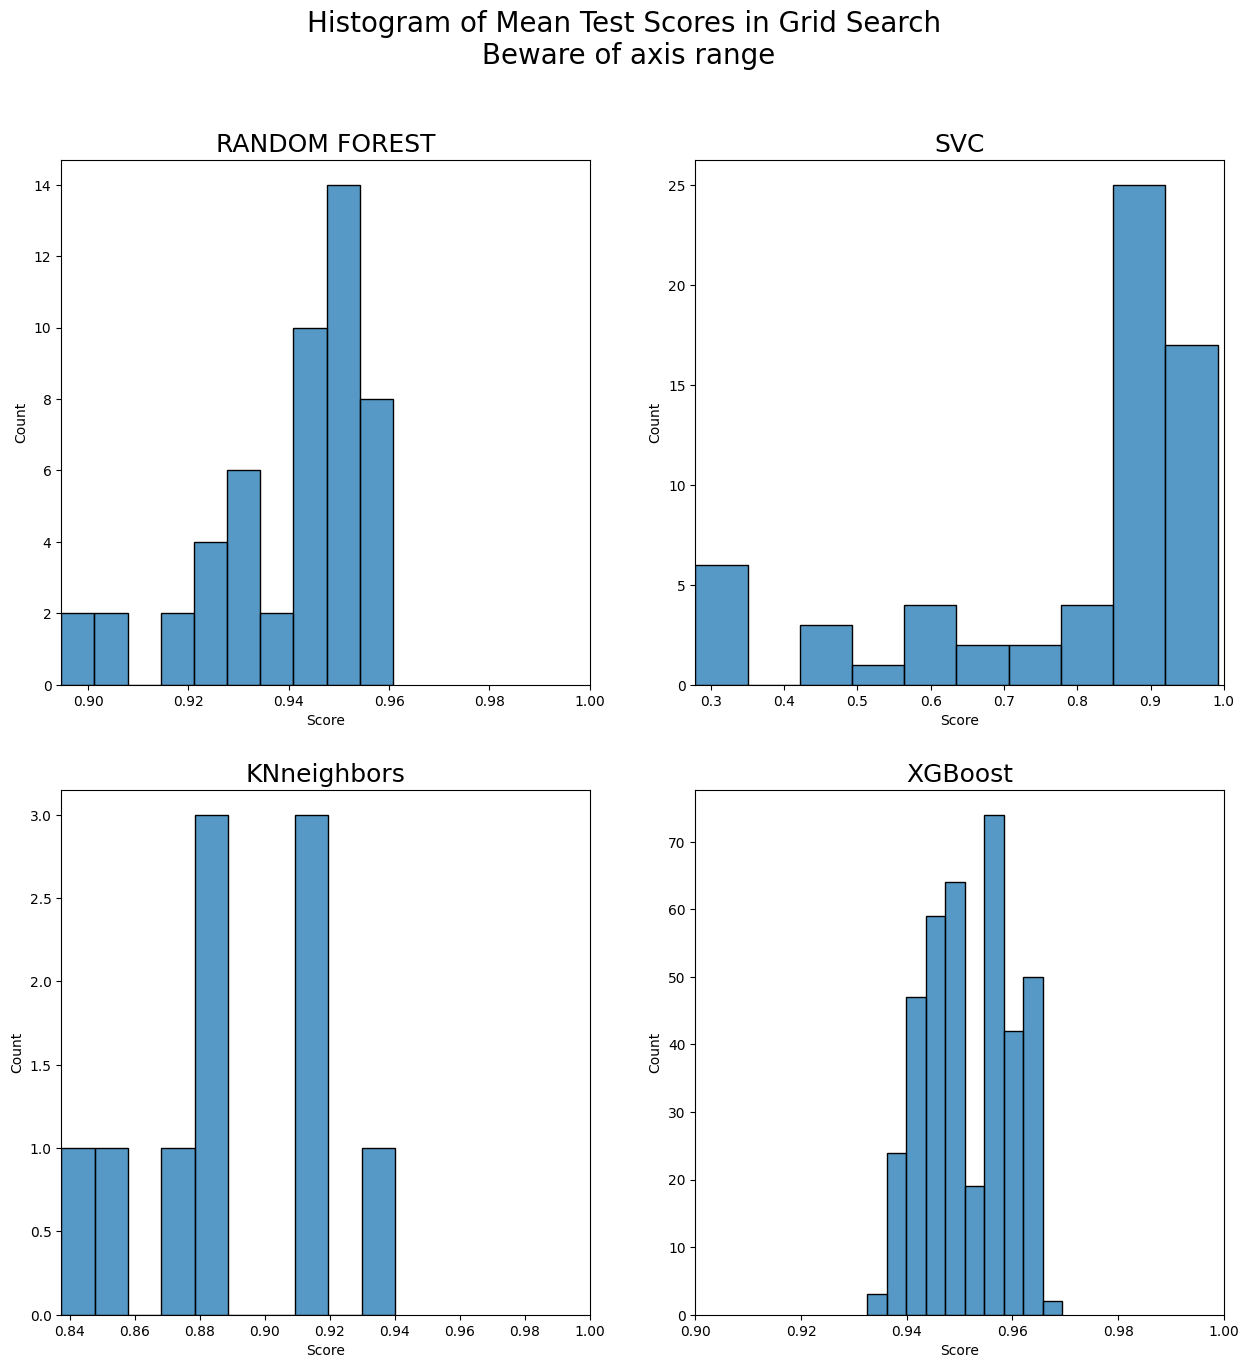

In [28]:
plt.figure(num=None, figsize=(15, 15))
       
ax = plt.subplot(2, 2, 1)
plot_hist_GridSearch(GridSearch_RF.cv_results_["mean_test_score"], "RANDOM FOREST")

ax = plt.subplot(2, 2, 2)
plot_hist_GridSearch(GridSearch_SVC.cv_results_["mean_test_score"], "SVC")

ax = plt.subplot(2, 2, 3)
plot_hist_GridSearch(GridSearch_KN.cv_results_["mean_test_score"], "KNneighbors")

ax = plt.subplot(2, 2, 4)
plot_hist_GridSearch(GridSearch_XGB.cv_results_["mean_test_score"], "XGBoost")

plt.suptitle("Histogram of Mean Test Scores in Grid Search\n Beware of axis range", fontsize = 20)

plt.savefig("/images/sep_lay_hist_binary.png", bbox_inches='tight')
plt.show()

**CONFUSION MATRICES**

*KNN neighbors* is the one that produces more mistakes. Howerver we have to take into account we have very few instances of HS, just 2.

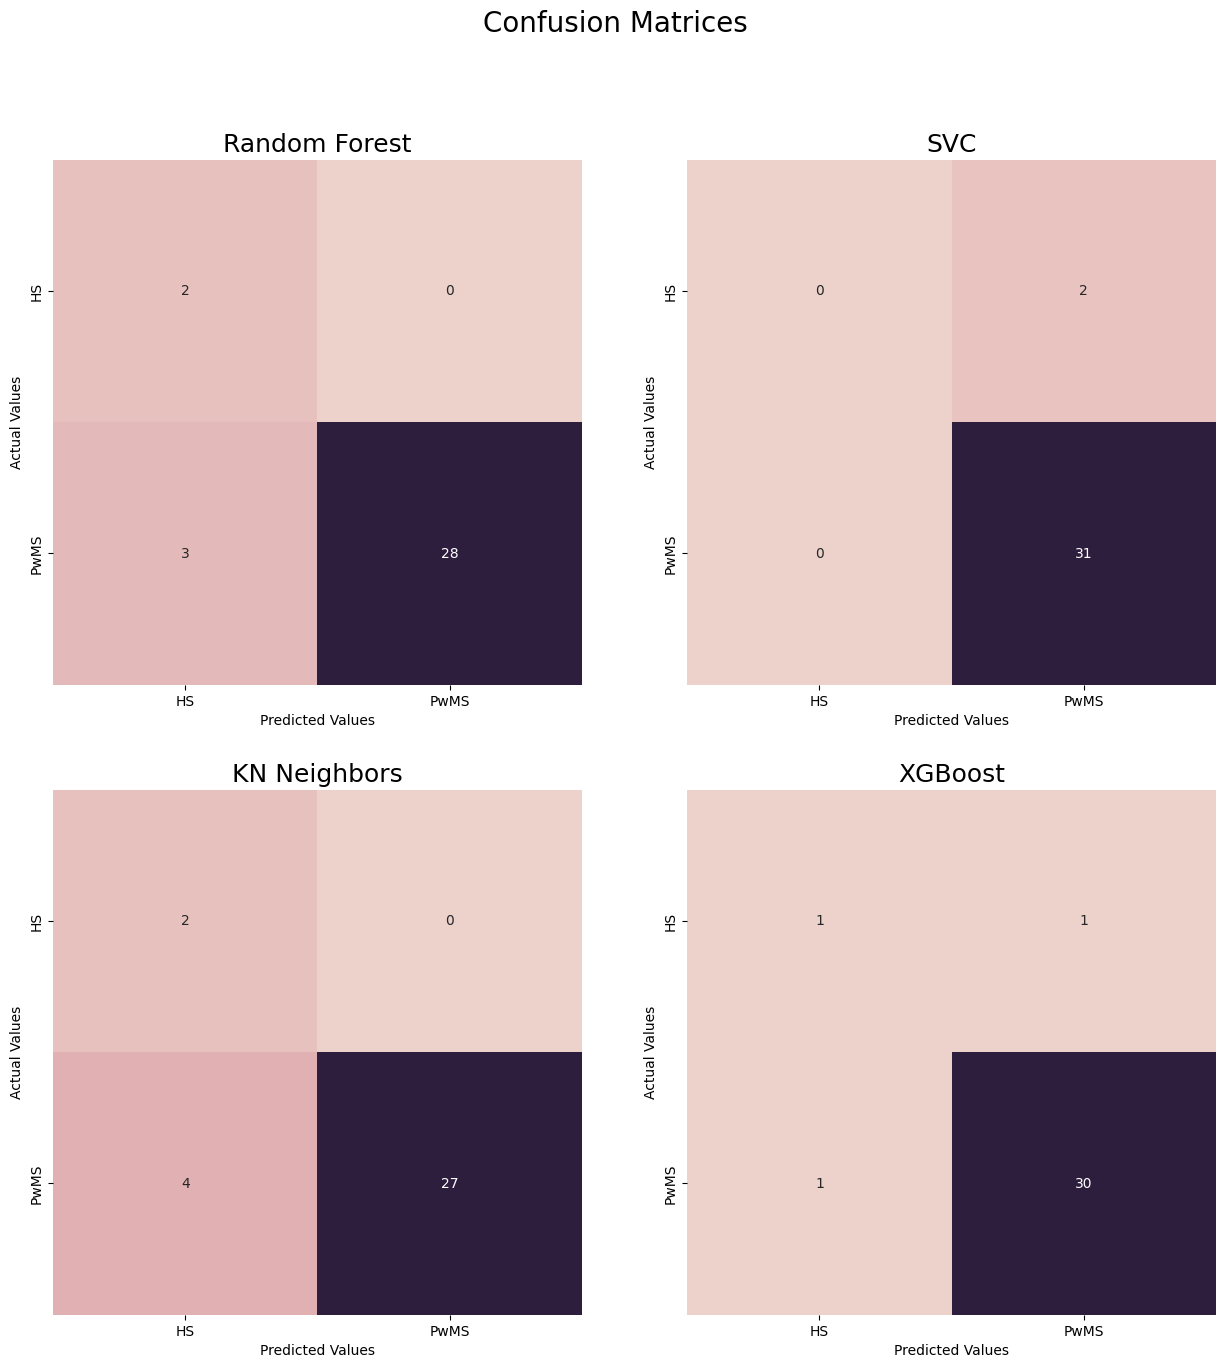

In [29]:
plt.figure(num=None, figsize=(15, 15))
       
ax = plt.subplot(2, 2, 1)
plot_confusion_matrix(rf_confMat, le_name_mapping.keys(), "Random Forest")

ax = plt.subplot(2, 2, 2)
plot_confusion_matrix(SVC_confMat, le_name_mapping.keys(), "SVC")

ax = plt.subplot(2, 2, 3)
plot_confusion_matrix(KN_confMat, le_name_mapping.keys(), "KN Neighbors")

ax = plt.subplot(2, 2, 4)
plot_confusion_matrix(XGB_confMat, le_name_mapping.keys(), "XGBoost")

plt.suptitle("Confusion Matrices", fontsize = 20)
plt.savefig("/images/sep_lay_confmat_binary.png", bbox_inches='tight')

plt.show()

**SCORE COMPARISON**

*Random Forest* and *XGBoost* yield quite similar results and superior to other two models, especially to *KN neighbors*

In [30]:
results_df = pd.concat([rf_pd, svc_pd, knn_pd, XGB_pd], axis = 1)
results_df = results_df.T
results_df

,accuracy,precision,recall,f1_score,roc_auc,False Positive (Type I),False Negative (Type II)
RandomForestClassifier,0.901425,0.943832,0.948551,0.944923,0.740942,0.0,3.0
SVC,0.871225,0.877994,0.991304,0.931079,0.495652,2.0,0.0
KNeighborsClassifier,0.818234,0.953387,0.835870,0.888201,0.759601,0.0,4.0
XGBClassifier,0.886895,0.950441,0.922826,0.934747,0.761413,1.0,1.0


### 4.6. FEATURE IMPORTANCE RANDOM FOREST AND XGBOOST, BINARY CLASSIFICATION

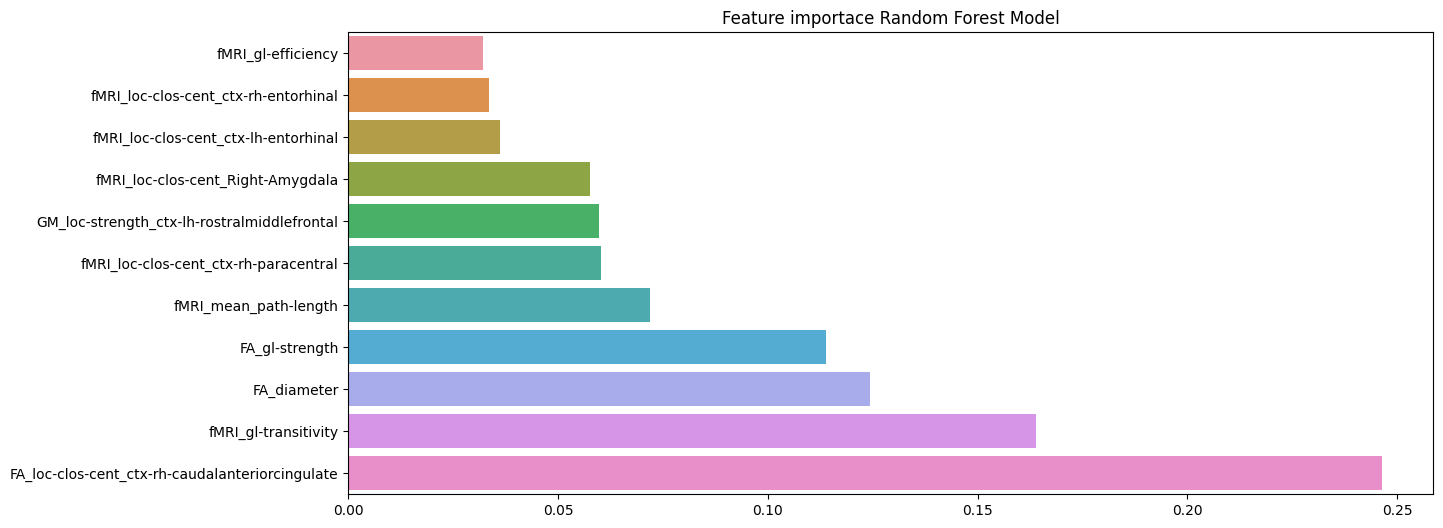

In [31]:
importances_rf = pd.Series(rf_model.feature_importances_, index = X.columns)
sorted_imp_rf = importances_rf.sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x = sorted_imp_rf.values, y = sorted_imp_rf.index)
plt.title('Feature importace Random Forest Model')
plt.show()

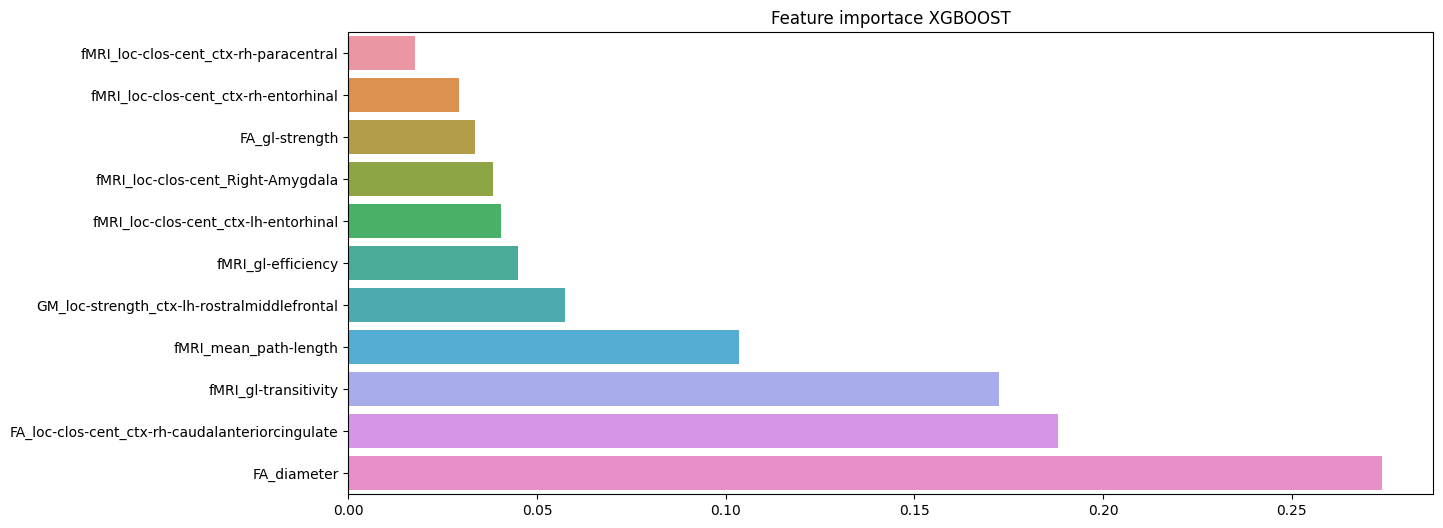

In [32]:
importances_XGB = pd.Series(XGB_model.feature_importances_, index = X.columns)
sorted_imp_XGB = importances_XGB.sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x = sorted_imp_XGB.values, y = sorted_imp_XGB.index)
plt.title('Feature importace XGBOOST')
plt.show()


## 5. MULTICLASS CLASSIFICATION 
## RRMS vs SPMS vs PPMS

Remove HS subjects from data and obtaining new train and test datasets

In [33]:
## Remove HS from our data
final_data_types = final_data[final_data.mstype != "HS"]


X = final_data_types.iloc[:,7:]
y = final_data_types["mstype"]
le = LabelEncoder()
y = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= RANDOM_STATE)

### 5.1. RANDOM FOREST FOR MULTICLASS

We have to set number of neighbors to a lower number than 3 cause we have very few data samples from our original dataset


In [34]:
param_grid = {
    'n_estimators': [50, 75, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 7, 10, 15]
}

GridSearch_RF = search_grid(RandomForestClassifier(random_state = RANDOM_STATE), param_grid, num_neighbors = 2)

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}


In [35]:
max_depth = GridSearch_RF.best_params_['max_depth']
max_features = GridSearch_RF.best_params_['max_features']
n_estimators = GridSearch_RF.best_params_['n_estimators']
model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, random_state = RANDOM_STATE)
rf_confMat, rf_model, rf_pd = create_model(X_train, X_test, y_train, y_test, model = model, num_neighbors = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.2. SVC FOR MULTICLASS

In [36]:
param_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 
                     'gamma': [1e-3, 1e-2, 0.1, 1],
                     'C': [0.1, 1, 10, 50, 100]}]

GridSearch_SVC = search_grid(SVC(random_state=RANDOM_STATE), param_grid, num_neighbors = 2)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [37]:
C = GridSearch_SVC.best_params_['C']
gamma = GridSearch_SVC.best_params_['gamma']
kernel = GridSearch_SVC.best_params_['kernel']
model = SVC(random_state = RANDOM_STATE, gamma = gamma, C = C, kernel = kernel)
SVC_confMat, SVC_model, svc_pd = create_model(X_train, X_test, y_train, y_test, model = model, num_neighbors = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

### 5.3. KNNEIGHBORS FOR MULTICLASS

In [38]:
param_grid = [{'n_neighbors': [2, 3, 4, 5, 6], 
                     'weights': ['uniform', 'distance']}]

GridSearch_KN = search_grid(KNeighborsClassifier(), param_grid, num_neighbors = 2)

{'n_neighbors': 2, 'weights': 'distance'}


In [39]:
n_neighbors = GridSearch_KN.best_params_['n_neighbors']
weights = GridSearch_KN.best_params_['weights']

model = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
KN_confMat, KN_model, knn_pd = create_model(X_train, X_test, y_train, y_test, model = model, num_neighbors = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.4. XGBOOST FOR MULTICLASS

In [40]:
from xgboost import XGBClassifier

param_grid =[{"learning_rate": [0.15, 0.20, 0.25],
              "max_depth": [ 3, 4, 5, 6],
                     "min_child_weight": [ 1, 3],
                     "gamma": [0.0, 0.05, 0.1, 0.2],
                     "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                     "verbosity": [0]}]# add this line to slient warning message
GridSearch_XGB = search_grid(XGBClassifier(random_state = RANDOM_STATE), param_grid, num_neighbors = 2)

{'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1, 'verbosity': 0}


In [41]:
learning_rate = GridSearch_XGB.best_params_["learning_rate"]
max_depth = GridSearch_XGB.best_params_["max_depth"]
min_child_weight =GridSearch_XGB.best_params_["min_child_weight"]
gamma = GridSearch_XGB.best_params_["gamma"]
colsample_bytree = GridSearch_XGB.best_params_["colsample_bytree"]



model = XGBClassifier(random_state = RANDOM_STATE, 
                      learning_rate = learning_rate, 
                      max_depth = max_depth,
                     min_child_weight = min_child_weight,
                     gamma = gamma,
                     colsample_bytree = colsample_bytree,
                     verbosity = 0)
XGB_confMat, XGB_model, XGB_pd = create_model(X_train, X_test, y_train, y_test,  model = model, num_neighbors = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.5. RESULTS FOR MULTICLASS CLASSIFICATION

**HISTOGRAMS OF GRID SEARCH RESULTS**

In this case we can see how for certain parameters random forest gives a poorer performance, while XGBOOST yield similar score for all parameters.

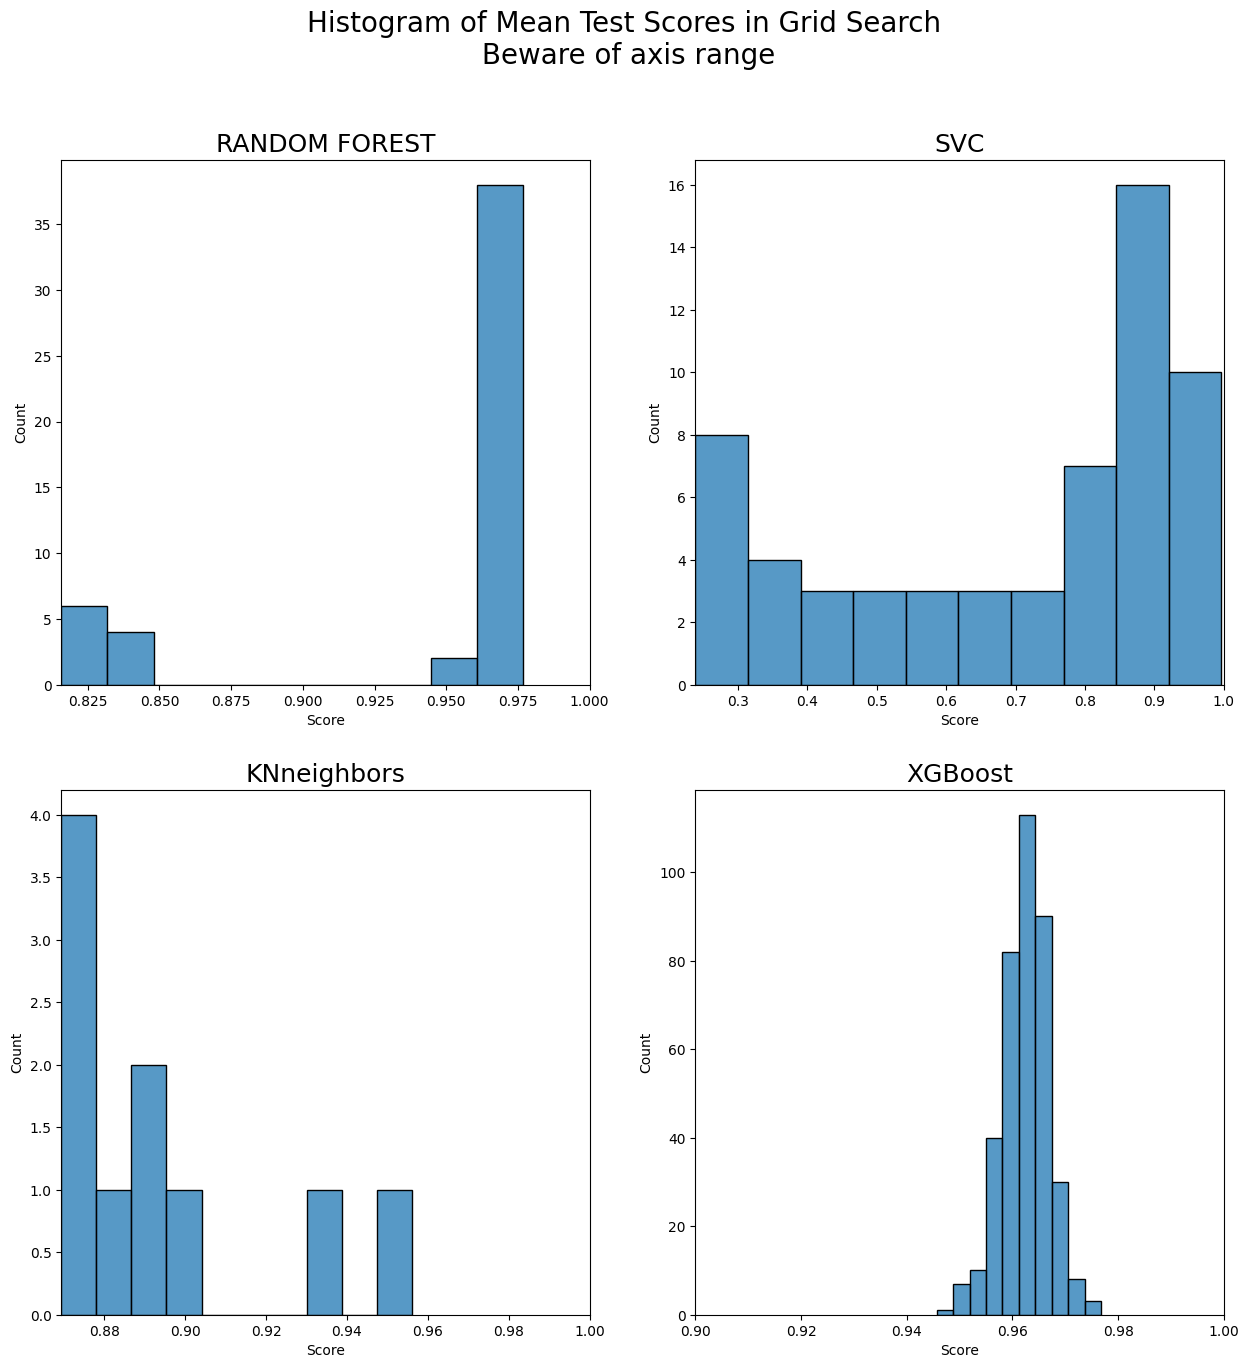

In [42]:
plt.figure(num=None, figsize=(15, 15))
       
ax = plt.subplot(2, 2, 1)
plot_hist_GridSearch(GridSearch_RF.cv_results_["mean_test_score"], "RANDOM FOREST")

ax = plt.subplot(2, 2, 2)
plot_hist_GridSearch(GridSearch_SVC.cv_results_["mean_test_score"], "SVC")

ax = plt.subplot(2, 2, 3)
plot_hist_GridSearch(GridSearch_KN.cv_results_["mean_test_score"], "KNneighbors")

ax = plt.subplot(2, 2, 4)
plot_hist_GridSearch(GridSearch_XGB.cv_results_["mean_test_score"], "XGBoost")

plt.suptitle("Histogram of Mean Test Scores in Grid Search\n Beware of axis range", fontsize = 20)
plt.savefig("/images/sep_lay_hist_multi.png", bbox_inches='tight')

plt.show()

**CONFUSION MATRICES**

We can see we obtain similar results in all models

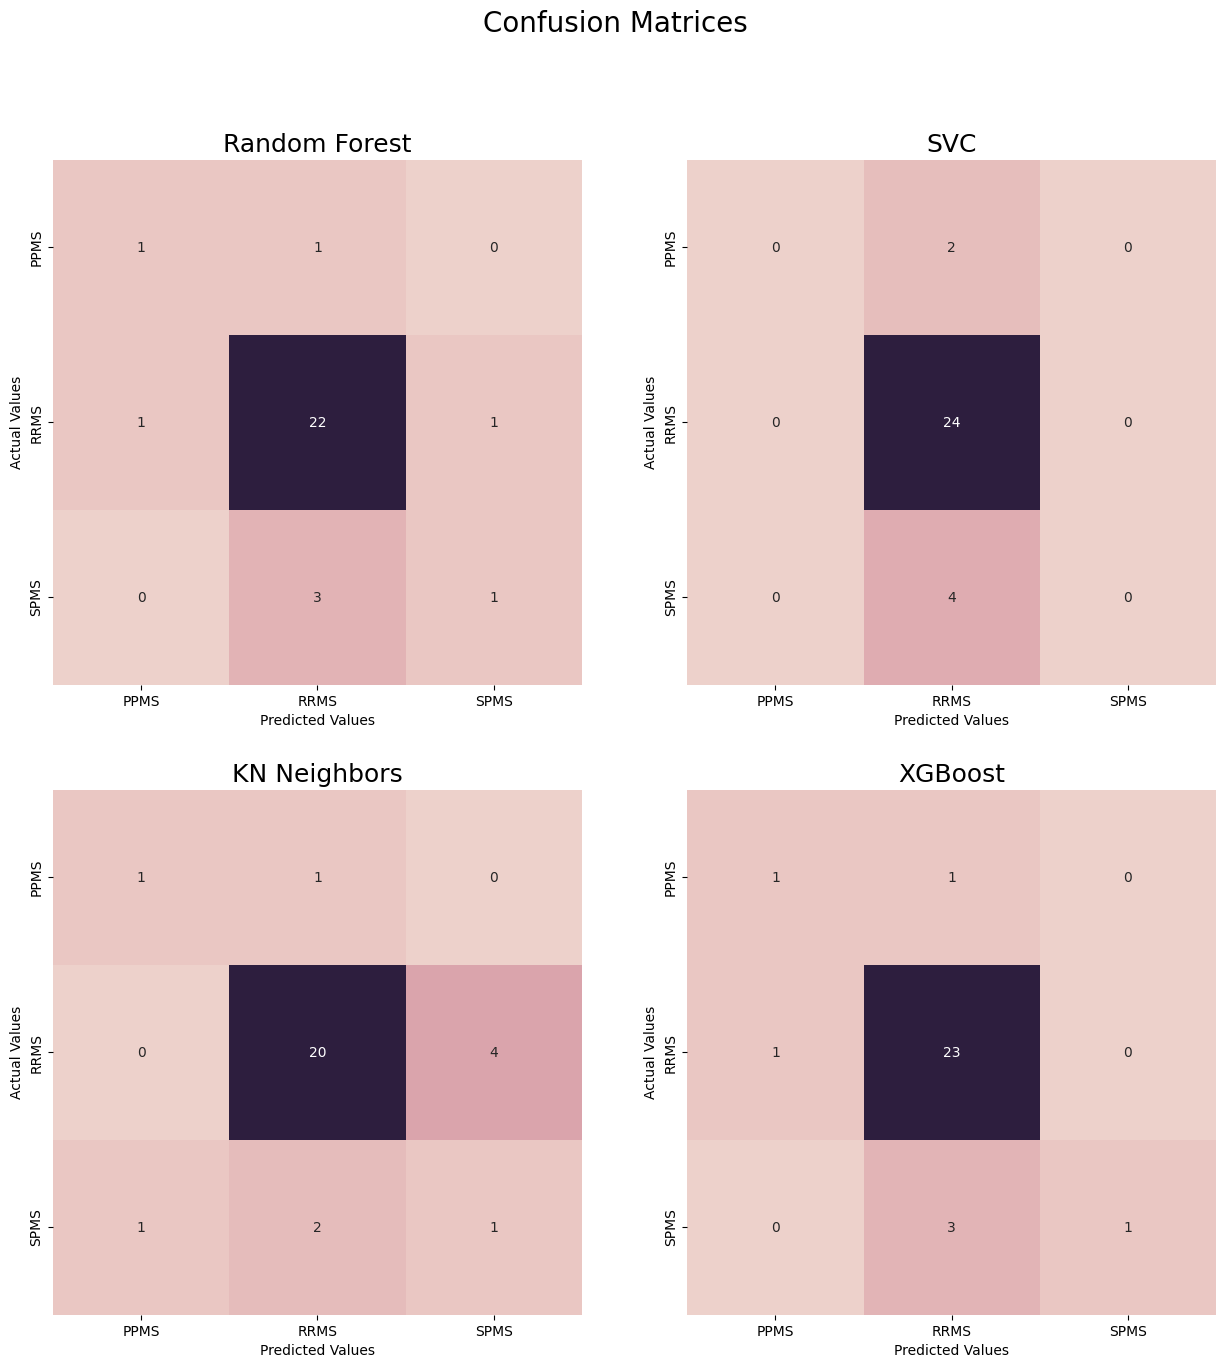

In [43]:
plt.figure(num=None, figsize=(15, 15))
       
ax = plt.subplot(2, 2, 1)
plot_confusion_matrix(rf_confMat, le_name_mapping.keys(), "Random Forest")

ax = plt.subplot(2, 2, 2)
plot_confusion_matrix(SVC_confMat, le_name_mapping.keys(), "SVC")

ax = plt.subplot(2, 2, 3)
plot_confusion_matrix(KN_confMat, le_name_mapping.keys(), "KN Neighbors")

ax = plt.subplot(2, 2, 4)
plot_confusion_matrix(XGB_confMat, le_name_mapping.keys(), "XGBoost")

plt.suptitle("Confusion Matrices", fontsize = 20)
plt.savefig("/images/sep_lay_confmat_multi.png", bbox_inches='tight')

plt.show()

**SCORE COMPARISON**

*KNNeighbors* produces poorer results than the rest of models

In [44]:
results_df = pd.concat([rf_pd, svc_pd, knn_pd, XGB_pd], axis = 1)
results_df = results_df.T
results_df

,accuracy,precision,recall,f1_score,Errors
RandomForestClassifier,0.837931,0.823367,0.837931,0.824525,6.0
SVC,0.854885,0.744154,0.854885,0.795629,6.0
KNeighborsClassifier,0.761207,0.836819,0.761207,0.787360,8.0
XGBClassifier,0.838506,0.800822,0.838506,0.818485,5.0


### 5.6. FEATURE IMPORTANCE RANDOM FOREST AND XGBOOST, MULTICLASS

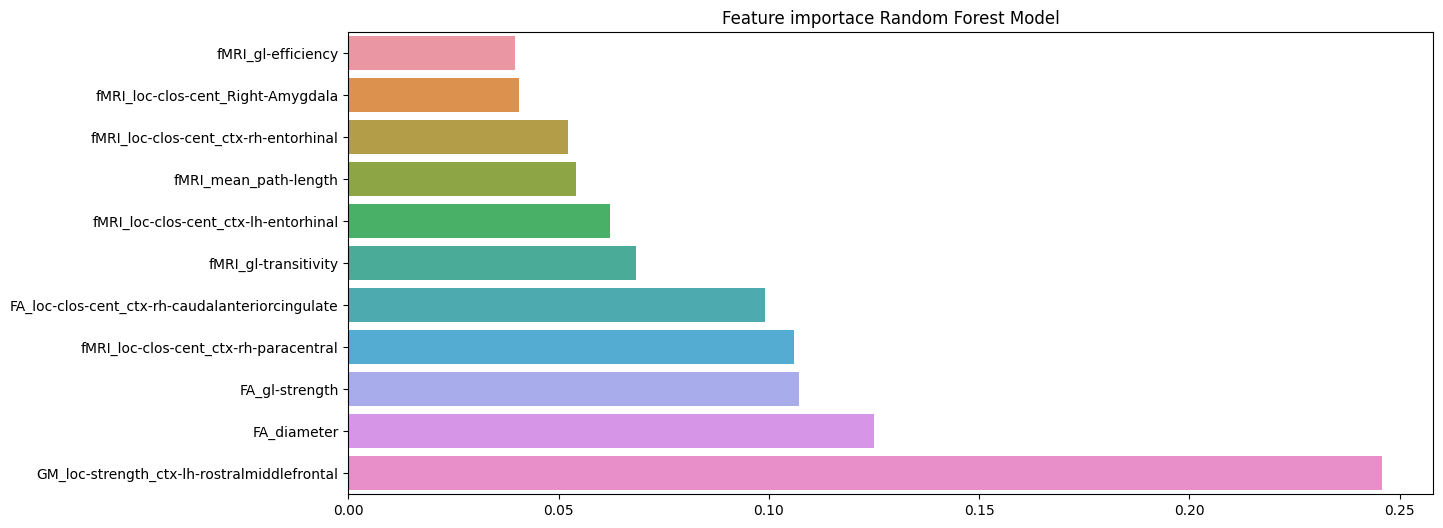

In [45]:
importances_rf = pd.Series(rf_model.feature_importances_, index = X.columns)
sorted_imp_rf = importances_rf.sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x = sorted_imp_rf.values, y = sorted_imp_rf.index)
plt.title('Feature importace Random Forest Model')
plt.show()

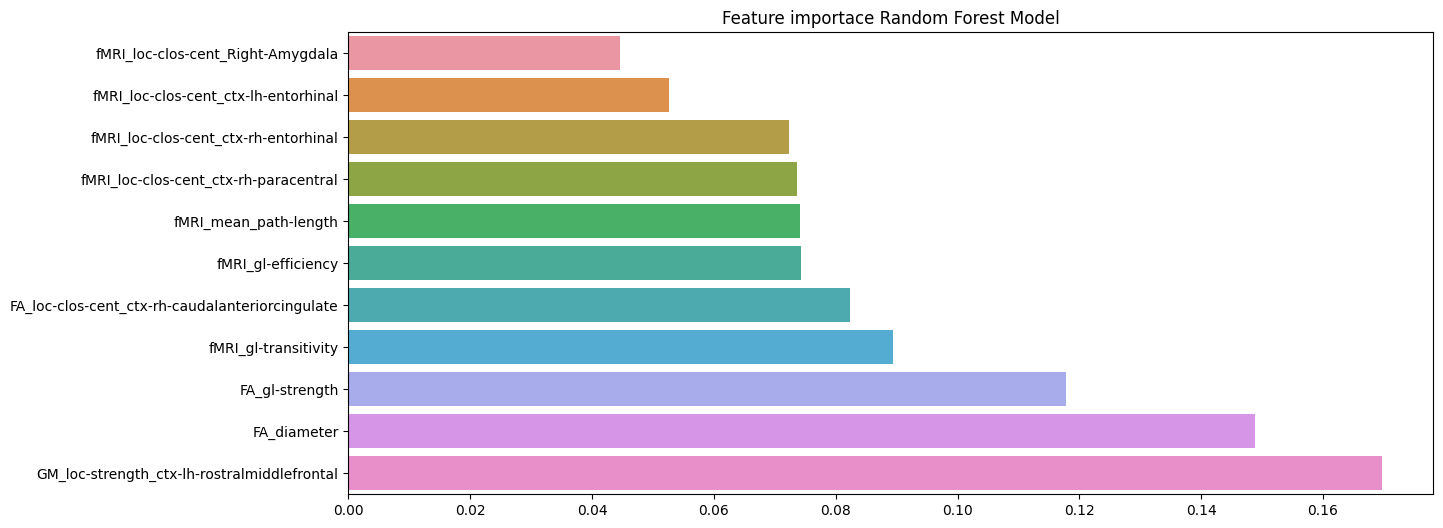

In [46]:
importances_xgb = pd.Series(XGB_model.feature_importances_, index = X.columns)
sorted_imp_xgb = importances_xgb.sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x = sorted_imp_xgb.values, y = sorted_imp_xgb.index)
plt.title('Feature importace Random Forest Model')
plt.show()